In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import tensorflow as tf
from scipy import stats
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2

from tqdm import tqdm
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib import cm

# Data
from seird.model import data_generator, version_data_model
from seird.sanity_checks import sampling_sc

# Model
from bayesflow.networks import SequenceNet, HeteroskedasticModel
from bayesflow.bayesflow_model import BayesFlow
from bayesflow.trainer import train_step
from bayesflow.losses import heteroskedastic_loss, maximum_likelihood_loss

# Misc
from utils.misc import (true_vs_estimated, plot_parameters_correlation, plot_tseries, plot_predictions)


%load_ext autoreload
%autoreload 2

In [3]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5

# Optional if using the predefined summary nets
summary_meta = {
    'lstm_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}


# Forward model hyperparameters
parameter_names = [r'$\beta$', r'$\sigma$', r'$\gamma$', r'$\delta$', r'$\eta$']
theta_dim = len(parameter_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = 'bayesflow_parameter_estimation_v1_1'
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000

starter_learning_rate = 0.001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [4]:
%%time
data_test = data_generator(n_test, version='v1_1')

# Preprocessing untrained data
X_test = np.array(data_test['X'])
params_test = np.array(data_test['params'])

CPU times: user 204 ms, sys: 5.99 ms, total: 210 ms
Wall time: 216 ms


In [5]:
print(type(X_test))
print(X_test.shape)
print(type(params_test))
print(params_test.shape)

<class 'numpy.ndarray'>
(500, 100, 5)
<class 'numpy.ndarray'>
(500, 5)


In [6]:
# Sanity checks for numerical stability
assert(np.sum(X_test == np.inf) == 0)
assert(np.sum(X_test == -np.inf) == 0)
assert(np.sum(X_test == np.nan) == 0)

In [7]:
print(X_test.shape)
print(params_test.shape)

(500, 100, 5)
(500, 5)


In [8]:
# Instantiate model
summary_net = SequenceNet()
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

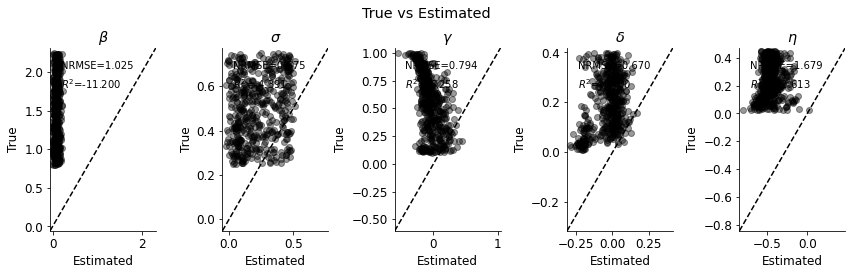

In [9]:
true_vs_estimated(model, X_test, params_test, n_samples_posterior, parameter_names, figsize=(12, 4))

In [10]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/bayesflow_parameter_estimation_v1_1/ckpt-100


In [ ]:
# %%time
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_step(
            model=model, 
            optimizer=optimizer,
            loss_fn=maximum_likelihood_loss, 
            iterations=iterations_per_epoch,
            batch_size=batch_size,
            p_bar=p_bar,
            global_step=global_step,
            version='v1_1'
        ) 

        # Manage checkpoint
        manager.save()

In [11]:
# Sample from trained model
params_samples = model.sample(X_test, n_samples_posterior, to_numpy=True)

# For each tseries compute mean of sampled posteriors
# For each tseries, n_samples_posterior set of parameters were samples
params_samples_mean = params_samples.mean(axis=0)

In [12]:
params_samples_mean.shape

(500, 5)

In [13]:
# Sampling sanity checks
sc_params_samples_mean, sc_params_test, sc_params_samples, sc_X_test = sampling_sc(params_samples_mean, params_test, params_samples, X_test, version='v1_1')

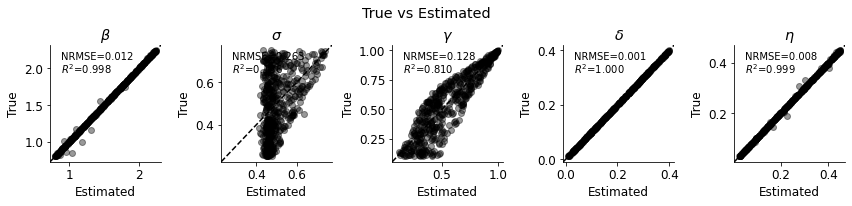

In [14]:
true_vs_estimated(model, sc_X_test, sc_params_test, n_samples_posterior, parameter_names, figsize=(12, 3), params_samples_mean=sc_params_samples_mean, filename='true_vs_estimated_v1_1')

In [15]:
# Select random tseries
sel_idx = np.random.choice(sc_params_samples_mean.shape[0], 1, replace=False)

In [16]:
sel_params_samples = sc_params_samples[:, sel_idx, :].squeeze()
sel_params_test = sc_params_test[sel_idx, :].squeeze()
sel_X_test = sc_X_test[sel_idx, :].squeeze().reshape(-1, 5)

<Figure size 432x288 with 0 Axes>

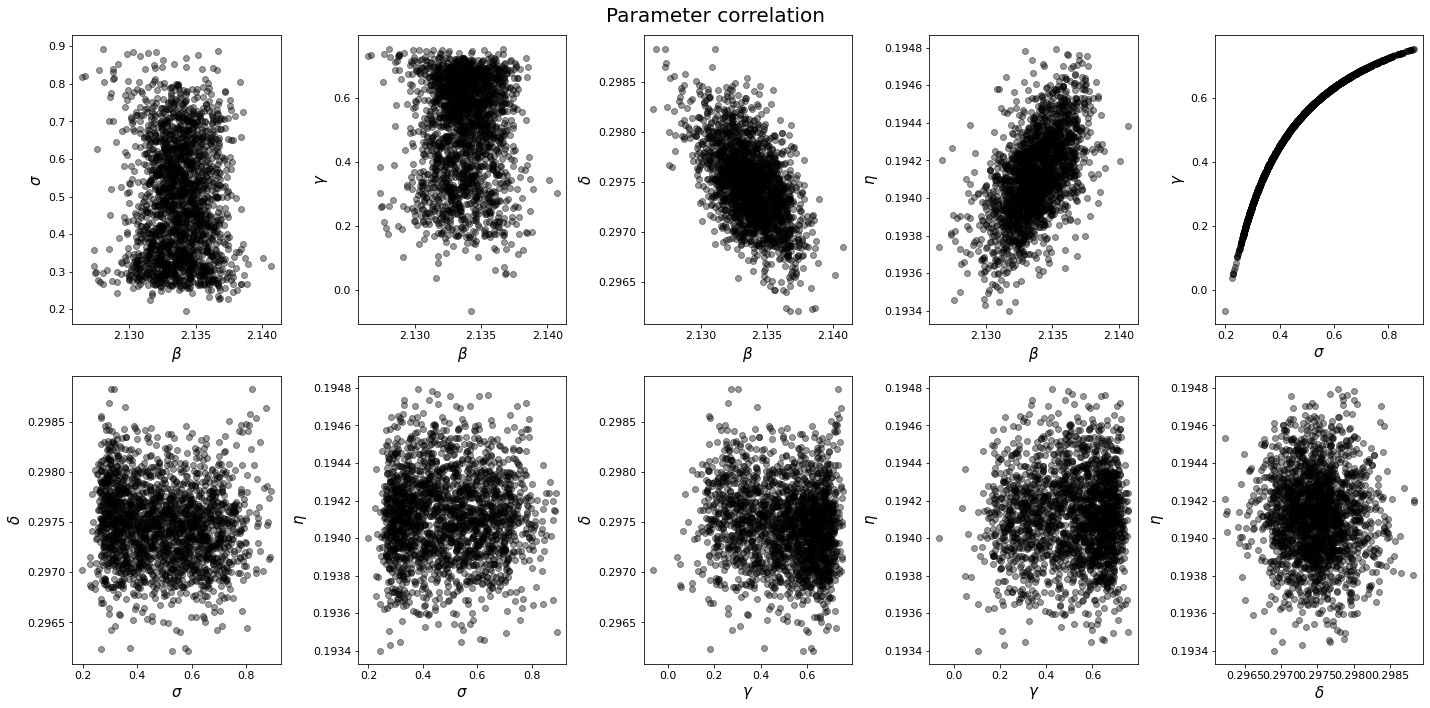

<Figure size 1440x720 with 0 Axes>

In [17]:
plot_parameters_correlation(sel_params_samples, parameter_names, filename='parameters_correlation_v1_1')

In [18]:
# Resimulation
t_obs = 100
dt = 1
t = np.linspace(0, t_obs, int(t_obs/dt))
N = 1000
init_vals = 1 - 1/N, 1/N, 0, 0, 0
forward_model = partial(version_data_model, initial_values=init_vals, version='v1_1')

In [19]:
tseries = np.empty((sel_params_samples.shape[0], t_obs, 5))
for i in range(sel_params_samples.shape[0]):
    tseries[i, :, :] = forward_model(sel_params_samples[i, :], t=t)

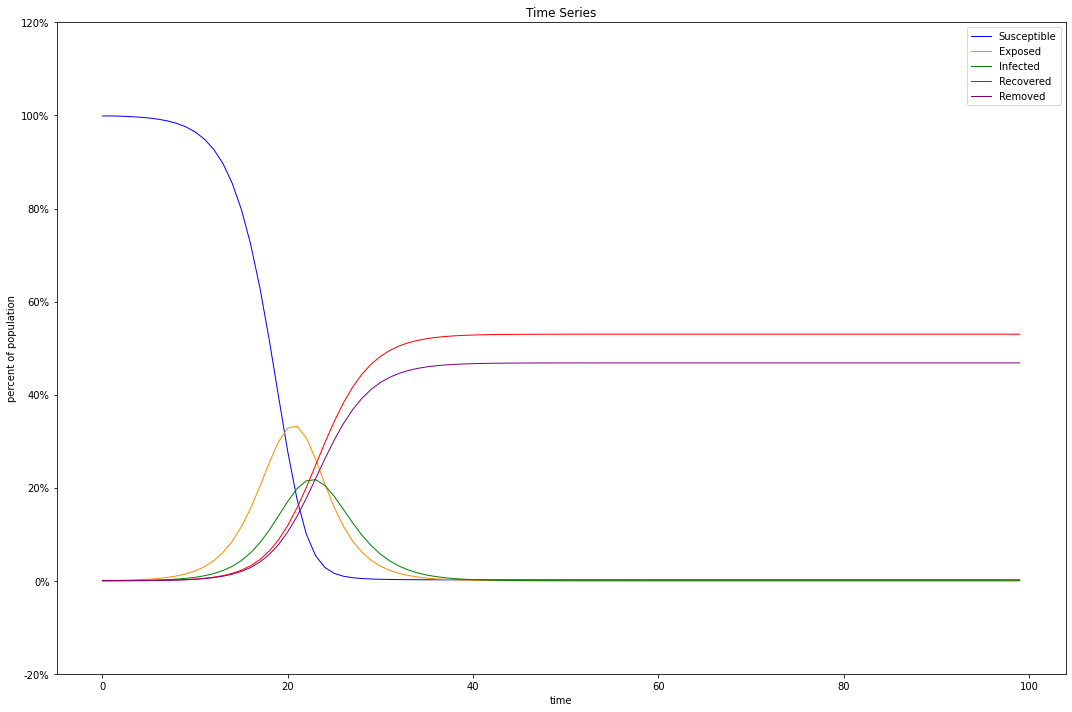

<Figure size 1080x720 with 0 Axes>

In [20]:
labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Removed']
plot_tseries(tseries, labels)

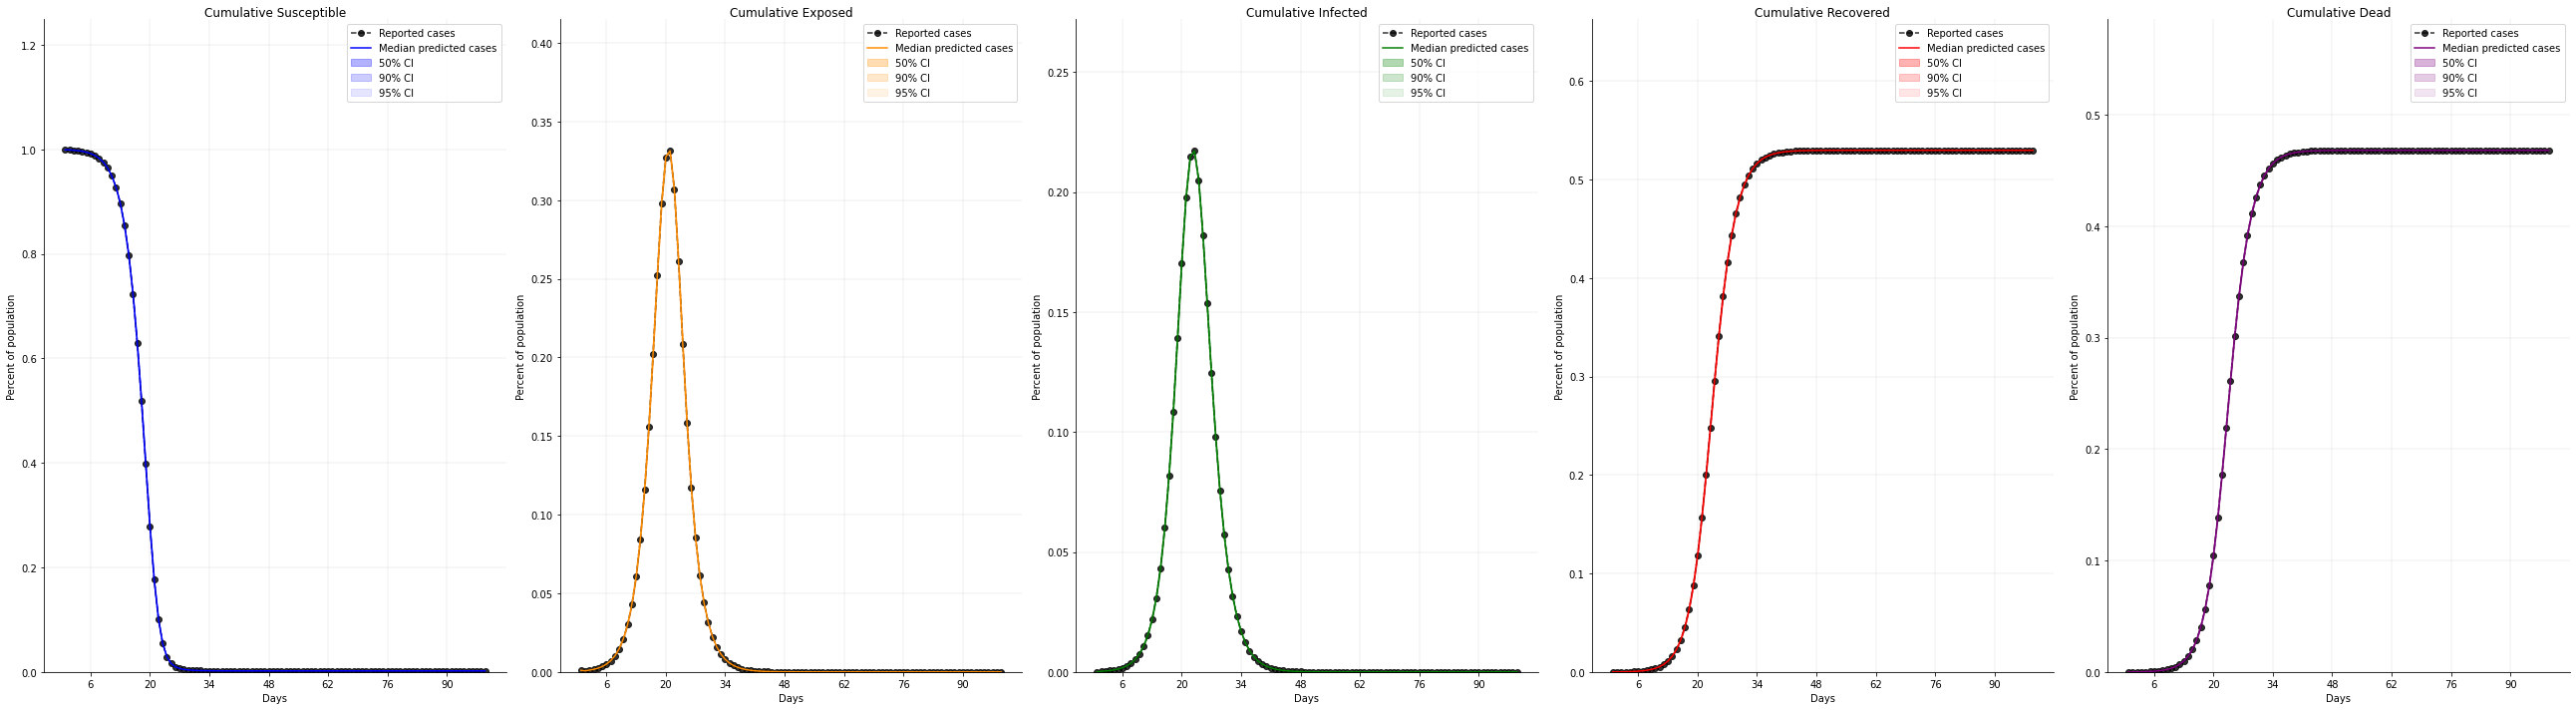

In [21]:
plot_predictions(t_obs, sel_X_test, tseries)